In [ ]:
import matplotlib.pyplot as plt
from utils.util_metrics import *
from utils.util_draw import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import json
import glob
import natsort as ns
import seaborn as sns
print(plt.style.available)
# import utils.ai_plotting as aiplt
# aiplt.aingura_plot_style(grid_color='white', plt_style='seaborn-v0_8-white')



['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [24]:
map_train = {'hamming':'HMD', 'shamming':'SHD', 'thamming':'THMD', 'Ratio Train':'HC Ratio'}
map_test = {'rmse':'RMSE', 'rmae':'RMAE(%)', 'Ratio Test':'Test ratio'}

def draw_plots_structure_results(all_df, all_df_std, models, M, save_path, save=True, draw=False):
    for col in ['hamming', 'shamming', 'thamming', 'Ratio Train']:
            markers = ['o', 's', '*', '^', 'v', 'p', 'D']  # Define a list of markers
            cmap = sns.color_palette("deep")
            sns.set_palette("deep")  

            if col != 'Ratio Train':
                maxval = all_df[col].values.max() + all_df_std[col].values.max() + 0.1
            else:
                maxval = all_df[col].values.max() + 0.75
                minval = -0.1
                

            fig, axes = plt.subplots(1, 4, figsize=(21, 6))
            for ax, simu in zip(axes.flatten(), [1,2,3,4]):
                all_df_simu = all_df[all_df['Simulation'] == simu]
                all_df_simu_std = all_df_std[all_df_std['Simulation'] == simu]
                
                bar_width = 0.2  # Width of the bars
                spacing = 0.03  # Space between groups of bars
                indexmodel = 0
                for model, color, mark in zip(models, cmap, markers):
                    g0 = all_df_simu.reset_index()
                    g1 = g0[g0['Model'] == model]
                    g0_std = all_df_simu_std.reset_index()
                    g2 = g0_std[g0_std['Model'] == model]
                    
                    if g1['hamming'].values[0] == -1: ## Dont plot rows with -1
                        continue
            
                    else:
                        if col == 'Ratio Train':
                            ax.errorbar(x=g1['Instances'].astype(int), y=g1[col], yerr=g2[col], color=color, marker=mark, capsize = 10, markersize=12, linewidth=2)
                            ax.set_title(f'Synthetic {simu}')
                            ax.set_xlabel('Number of instances')
                            ax.set_ylim(minval,maxval)
                            if ax != axes[0]:
                                ax.set_yticklabels([]) # Hide y-axis for other subplots
                            else:
                                ax.set_ylabel(map_train[col])
                            ax.tick_params(axis='both', which='major')
                            ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed

                        else:
                            x = np.arange(len(g1['Instances'])) * (len(models) * (bar_width + spacing))  # Adjust x positions
                            indexmodel += 1
                            ax.bar(x + bar_width * indexmodel, g1[col].values, yerr=g2[col].values,  width=bar_width, color=color, edgecolor='white', ecolor='#3b3b3b', capsize=5)
    
                            ax.set_title(f'Synthetic {simu}')
                            ax.set_xlabel('Number of instances')
                     
                            if ax != axes[0]:
                                ax.set_yticklabels([]) # Hide y-axis for other subplots
                            else:
                                ax.set_ylabel(map_train[col])
                            ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
                            ax.set_xticklabels(g1['Instances'])
                            ax.set_ylim(0,maxval)
                            ax.tick_params(axis='y', which='major')
                            ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed

            if col == 'Ratio Train':
                handles = [Line2D([0], [0], 
                        color=cmap[i], 
                        marker=markers[i], 
                        linestyle='-', 
                        markersize=12, 
                        linewidth=2, 
                        label=models[i][2:]) for i in range(len(models))]
            else:
                handles = [Patch(color=cmap[i], label=models[i][2:]) for i in range(len(models))]
            fig.legend(handles=handles, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
            fig.tight_layout(w_pad=0.5)
            if save:
                os.makedirs(f"{save_path}/plots/{M}", exist_ok=True)
                fig.savefig(f'{save_path}/plots/{M}/{col}.pdf', format='pdf', bbox_inches='tight')
            if not draw:
                plt.close()

In [25]:
def draw_plots_structure_results_M(concat_all, concat_all_std, models, save_path, save=True, draw=False):
    for col in ['hamming', 'shamming', 'thamming', 'Ratio Train']:
        markers = ['o', 's', '*', '^', 'v', 'p', 'D']  # Define a list of markers
        cmap = sns.color_palette("deep")
        sns.set_palette("deep")  
        
        fig, axes = plt.subplots(1, 4, figsize=(21, 6))

        if col != 'Ratio Train':
            maxval = concat_all[concat_all['Instances'] == f'{2**14}'][col].values.max() + concat_all_std[col].values.max() + 0.2
        else: 
            maxval =  concat_all[concat_all['Instances'] == f'{2**14}'][col].values.max() + 1
            minval = -0.1

        for ax, simu in zip(axes.flatten(), [1,2,3,4]):
            instances = 2**14
            all_df_simu = concat_all[concat_all['Simulation'] == simu]
            all_df_M = all_df_simu[all_df_simu['Instances'] == f'{instances}']
            all_df_simu_std = concat_all_std[concat_all_std['Simulation'] == simu]
            all_df_M_std = all_df_simu_std[all_df_simu_std['Instances'] == f'{instances}']


            bar_width = 0.2  # Width of the bars
            spacing = 0.03  # Space between groups of bars
            indexmodel = 0
            for model, color, mark in zip(models, cmap, markers):
                g0 = all_df_M.reset_index()
                g1 = g0[g0['Model'] == model]
                g0_std = all_df_M_std.reset_index()
                g2 = g0_std[g0_std['Model'] == model]
                
                if g1['hamming'].values[0] == -1:
                    continue
                else:
                    if col == 'Ratio Train':
                        ax.errorbar(x=g1['M'].astype(int), y=g1[col], yerr=g2[col], color=color, marker=mark, capsize = 10, markersize=12, linewidth=2)
                        ax.set_title(f'Synthetic {simu}')
                        ax.set_xlabel(r'$M$')
                        ax.set_ylim(minval, maxval)
                        if ax != axes[0]:
                            ax.set_yticklabels([]) # Hide y-axis for other subplots
                        else:
                            ax.set_ylabel(map_train[col])
                        ax.tick_params(axis='both', which='major')
                        ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed
            
                    else:
                        x = np.arange(len(g1['M'])) * (len(models) * (bar_width + spacing))  # Adjust x positions
                        indexmodel += 1
                        ax.bar(x + bar_width * indexmodel, g1[col].values, yerr=g2[col].values, width=bar_width, color=color, edgecolor='white',ecolor='#3b3b3b', capsize=5)
                        ax.set_title(f'Synthetic {simu}')
                        ax.set_xlabel(r'$M$')
                        if ax != axes[0]:
                            ax.set_yticklabels([]) # Hide y-axis for other subplots    
                        else:
                            ax.set_ylabel(map_train[col])
                        ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
                        ax.set_xticklabels(g1['M'])
                        ax.set_ylim(0,maxval)
                        ax.tick_params(axis='y', which='major')
                        ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed

        if col == 'Ratio Train':
            handles = [Line2D([0], [0], 
                    color=cmap[i], 
                    marker=markers[i], 
                    linestyle='-', 
                    markersize=12, 
                    linewidth=2, 
                    label=models[i][2:]) for i in range(len(models))]
        else:
            handles = [Patch(color=cmap[i], label=models[i][2:]) for i in range(len(models))]
        fig.legend(handles=handles, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
        fig.tight_layout(w_pad=0.5)
        if save:
            os.makedirs(f"{save_path}/plots_Nfix/", exist_ok=True)
            fig.savefig(f'{save_path}/plots_Nfix/{col}.pdf', format='pdf', bbox_inches='tight')
        if not draw:
                plt.close()

In [26]:
def draw_plots_test_results(all_df, models, M, save_path, save=True, draw=False):
    for col in ['rmse', 'rmae', 'Ratio Test']:
        markers = ['o', 's', '*', '^', 'v', 'p', 'D']  # Define a list of markers
        cmap = sns.color_palette("deep")
        sns.set_palette("deep")  

        fig, axes = plt.subplots(1, 4, figsize=(21, 6))
        fig.subplots_adjust(wspace=0)
        for ax, simu in zip(axes.flatten(),[1,2,3,4]):
            all_df_simu = all_df[all_df['Simulation'] == simu]
            
            if col !='Ratio Test':
                dfmodel = all_df[col].values
                maxval = dfmodel.max() + 0.02
            
            for model, color, mark in zip(models, cmap, markers):
                g0 = all_df_simu.reset_index()
                g1 = g0[g0['Model'] == model]
                
                if g1['rmse'].values[0] == -1:
                    continue
                else:
                    ax.plot(g1['Instances'].astype(int), g1[col], color=color, label=model, marker=mark, markersize=12, linewidth=2)
                    ax.set_title(f'Synthetic {simu}')
                    ax.set_xlabel('Number of instances')
                    if col !='Ratio Test':
                        ax.set_ylim(-0.05,maxval+0.05)                                               
                    if ax != axes[0] and col != 'Ratio Test':
                        ax.set_yticklabels([])
                    else:
                        ax.set_ylabel(map_test[col])
                    ax.tick_params(axis='both', which='major')
                    ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed
                        
        handle = [Line2D([0], [0], 
                color=cmap[i], 
                marker=markers[i], 
                linestyle='-', 
                markersize=12, 
                linewidth=2, 
                label=models[i][2:]) for i in range(len(models))]
        
        fig.legend(handles=handle, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
        fig.tight_layout(w_pad=0.8)
        if save:
            os.makedirs(f"{save_path}/plots/{M}", exist_ok=True)
            fig.savefig(f'{save_path}/plots/{M}/{col}.pdf', format='pdf', bbox_inches='tight')
        if not draw:
            plt.close()

In [27]:
def draw_plots_test_results_M(concat_all, models, save_path, save=True, draw=False):
    for col in ['rmse', 'rmae', 'Ratio Test']:
        markers = ['o', 's', '*', '^', 'v', 'p', 'D']  # Define a list of markers
        cmap = sns.color_palette("deep")
        sns.set_palette("deep")  

        fig, axes = plt.subplots(1, 4, figsize=(21, 6))
        fig.subplots_adjust(wspace=0)
        for ax, simu in zip(axes.flatten(), [1,2,3,4]):
            instances = 2**14
            all_df_simu = concat_all[concat_all['Simulation'] == simu]
            all_df_M = all_df_simu[all_df_simu['Instances'] == f'{instances}']
            
            if col !='Ratio Test':
                dfmodel = concat_all[col].values           
                maxval = dfmodel.max() +0.02

            for model, color, mark in zip(models, cmap, markers):
                g0 = all_df_M.reset_index()
                g1 = g0[g0['Model'] == model]

                if g1['rmse'].values[0] == -1:
                    continue
                else:
                    ax.plot(g1['M'].astype(int), g1[col], color=color, label=model, marker=mark, markersize=12, linewidth=2)
                    ax.set_title(f'Synthetic {simu}')
                    ax.set_xlabel(r'$M$')
                    if col !='Ratio Test':
                        ax.set_ylim(-0.05,maxval+0.05)                 
                    if ax != axes[0] and col != 'Ratio Test':
                        ax.set_yticklabels([])
                    else:
                        ax.set_ylabel(map_test[col])
                    ax.tick_params(axis='both', which='major')
                    ax.grid(axis='y', linestyle='-', color='gray', alpha=0.5)  # Customize as needed
                        
        handle = [Line2D([0], [0], 
                color=cmap[i], 
                marker=markers[i], 
                linestyle='-', 
                markersize=12, 
                linewidth=2, 
                label=models[i][2:]) for i in range(len(models))]
        
        fig.legend(handles=handle, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))
        fig.tight_layout(w_pad=0.5)
        if save:
            os.makedirs(f"{save_path}/plots_Nfix/", exist_ok=True)
            fig.savefig(f'{save_path}/plots_Nfix/{col}.pdf', format='pdf', bbox_inches='tight')
        if not draw:
            plt.close()

#### Plot Structure Results

In [28]:

exp = f'results/exp_simu/Mfix/'
thres = 0.5
paths = ns.natsorted(glob.glob(f'{exp}/simu*.json'))
print(paths)
# Load results from JSON files

all_exps = []
all_exps_std = []
models = ['1.SPBN','2.B-SPBN-Simple','3.B-SPBN-Linear', '4.B-SPBN-FKDE-Simple','5.B-SPBN-FKDE-Linear']
for path in paths:
    M = int(path.split('.')[0].split('_')[-1])
    with open(path, 'r') as json_file:
        results = json.load(json_file)
    
        dataframes = []
        model_index, instances_col,simucol = [],[],[]
        for nm, model in enumerate(models):
            instances = ns.natsorted(results[model].keys())
            for n in instances:
                simus = results[model][n].keys()
                for simu in simus:
                    ## PREPARE DATAFRAMES
                    reader = ExperimentsReader(results[model][n][simu], model, 'REF')
                    df_all = reader.return_dataframe(simulated=True).reset_index().drop(columns=['model'],axis=1)
                    
                    reader0 = ExperimentsReader(results[models[0]][n][simu], models[0], 'REF')
                    df0 = reader0.return_dataframe(simulated=True).reset_index()

                    df_all['Ratio Train'] = df0['train']/df_all['train']
                    df_all['Logl diff'] = df_all['slogl_REF'] - df_all['slogl']
                    df_all['Ratio Test'] = df_all['test_REF']/df_all['test']
                    
                    df_mean = df_all.mean().to_frame().T
                    df_std = df_all.std().to_frame().T
                    dataframes.append((df_all, df_mean, df_std))
                

                    ## GET CONSENSUS GRAPH
                    kwargs = reader.return_average_dag(model, thres, df_all['index'].tolist())
                    config = get_config(int(simu[-1]))
                    ref_model = pbn.SemiparametricBN(**config)
                    if len(kwargs['arcs']) > 0:
                        avg_model = pbn.BinnedSPBN(**kwargs) if model[2:8] == "B-SPBN" else pbn.SemiparametricBN(**kwargs)
                                                
                        # hmd = hamming_distance(avg_model.arcs(), ref_model.arcs(), reader.nodemap)
                        # shd = structural_hamming_distance(avg_model.arcs(), ref_model.arcs())
                        # thmd = node_type_hamming_distance(avg_model.node_types(), ref_model.node_types())
                        # consensus_distances = pd.DataFrame({'hamming': [hmd], 'shamming': [shd], 'thamming': [thmd]})
                        # print(consensus_distances)

                        dagpath = f"{exp}/comparison_dag/{M}/{model}"
                        os.makedirs(dagpath, exist_ok=True)
                        compare_graphs(ref_model, avg_model, filename=dagpath+f"/{simu}_{n}.pdf", size=20)

                    model_index.append(model)                 
                    instances_col.append(n) 
                    simucol.append(int(simu[-1]))

                
        all_df= pd.concat([df_mean for _, df_mean,_ in dataframes]).reset_index(drop=True).drop(columns=['index'], axis=1)
        all_df.index = model_index
        all_df.index.name = 'Model'
        all_df['Instances'] = instances_col
        all_df['Simulation'] = simucol
        all_df['M'] = [M]*len(all_df)


        all_df_std= pd.concat([df_std for _, _,df_std in dataframes]).reset_index(drop=True).drop(columns=['index'], axis=1)
        all_df_std.index = model_index
        all_df_std.index.name = 'Model'
        all_df_std['Instances'] = instances_col
        all_df_std['Simulation'] = simucol
        all_df_std['M'] = [M]*len(all_df_std)


        all_exps.append(all_df)
        all_exps_std.append(all_df_std)
        # print(all_df.to_string())


        draw_plots_structure_results(all_df, all_df_std, models, M, exp)

['results/exp_simu/Mfix/simu_all_50.json', 'results/exp_simu/Mfix/simu_all_80.json', 'results/exp_simu/Mfix/simu_all_100.json', 'results/exp_simu/Mfix/simu_all_125.json']


In [29]:
concat_all = pd.concat(all_exps)
concat_all_std = pd.concat(all_exps_std)
draw_plots_structure_results_M(concat_all, concat_all_std, models, exp)

#### Bergam-Hommel preparation
The bergamn-hommel analysis is performed in Rstudio. Then the CDD is plotted in python again

In [16]:
prepare_CD = concat_all.reset_index()
prepare_CD['Model'] = prepare_CD['Model'].apply(lambda x: x[2:])
prepare_CD34 = prepare_CD[((prepare_CD['Simulation']==3)|(prepare_CD['Simulation']==4))]
prepare_CD12 = prepare_CD[((prepare_CD['Simulation']==1)|(prepare_CD['Simulation']==2))]
prepare_CD12 = prepare_CD12[(prepare_CD12['Model'] != 'B-SPBN-FKDE-Linear')&(prepare_CD12['Model'] != 'B-SPBN-FKDE-Simple')]

prepare_CD34['Simu_Inst'] = prepare_CD34['Simulation'].astype(str) + '_' + prepare_CD34['Instances'] + '_' + prepare_CD34['M'].astype(str)
prepare_CD12['Simu_Inst'] = prepare_CD12['Simulation'].astype(str) + '_' + prepare_CD12['Instances'] + '_' + prepare_CD12['M'].astype(str)

for prepare, pth in zip([prepare_CD12, prepare_CD34],[f"critical_diff/all_S12",f"critical_diff/all_S34"]):
    hmd_cd = prepare[['Model', 'Simu_Inst', 'hamming']]
    shd_cd = prepare[['Model','Simu_Inst','shamming']]
    thmd_cd = prepare[['Model','Simu_Inst','thamming']]

    hmd_cd.columns = ['network', 'dataset_name', 'metric']
    hmd_cd['dataset_name'] = hmd_cd['dataset_name'].astype(str)
    shd_cd.columns = ['network', 'dataset_name', 'metric']
    shd_cd['dataset_name'] = shd_cd['dataset_name'].astype(str)
    thmd_cd.columns = ['network', 'dataset_name', 'metric']
    thmd_cd['dataset_name'] = thmd_cd['dataset_name'].astype(str)

    transformed_hmd_cd = hmd_cd.pivot(index='dataset_name', columns='network', values='metric')
    transformed_shd_cd = shd_cd.pivot(index='dataset_name', columns='network', values='metric')
    transformed_thmd_cd = thmd_cd.pivot(index='dataset_name', columns='network', values='metric')
    print(transformed_hmd_cd)
    os.makedirs(pth, exist_ok=True)
    transformed_hmd_cd.to_csv(pth+ "/hmd.csv", index=False)
    transformed_shd_cd.to_csv(pth+ "/shd.csv", index=False)
    transformed_thmd_cd.to_csv(pth+ "/thmd.csv", index=False)


network       B-SPBN-Linear  B-SPBN-Simple  SPBN
dataset_name                                    
1_16384_100             0.0            0.4   0.2
1_16384_125             0.0            0.0   0.2
1_16384_50              0.2            0.2   0.4
1_16384_80              0.2            0.2   0.0
1_2048_100              0.0            0.0   0.0
1_2048_125              0.0            0.0   0.2
1_2048_50               0.2            0.2   0.2
1_2048_80               0.0            0.0   0.0
1_4096_100              0.8            0.6   0.4
1_4096_125              0.2            0.2   0.2
1_4096_50               0.6            0.6   0.0
1_4096_80               0.2            0.4   0.4
1_8192_100              0.4            0.4   0.2
1_8192_125              0.6            0.2   0.4
1_8192_50               0.4            0.6   0.2
1_8192_80               0.0            0.0   0.4
2_16384_100             1.2            1.2   1.0
2_16384_125             1.0            1.0   2.2
2_16384_50          

#### Draw Test Results

In [30]:
exp = f'results/exp_simu/Mfix_sameDAG'
paths = ns.natsorted(glob.glob(f'{exp}/simu*.json'))
print(paths)

all_exps = []
all_exps_std = []
models = ['1.SPBN','2.B-SPBN-Simple','3.B-SPBN-Linear', '4.B-SPBN-FKDE-Simple','5.B-SPBN-FKDE-Linear']
for path in paths:
    M = int(path.split('.')[0].split('_')[-1])
    with open(path, 'r') as json_file:
        results = json.load(json_file)
    
        dataframes = []
        model_index, instances_col,simucol = [],[],[]
        for nm, model in enumerate(models):
            instances = ns.natsorted(results[model].keys())
            for n in instances:
                simus = results[model][n].keys()
                for simu in simus:
                    ## PREPARE DATAFRAMES
                    reader = ExperimentsReader(results[model][n][simu], model, 'REF')
                    df_all = reader.return_dataframe(simulated=True).reset_index().drop(columns=['model'],axis=1)
                    
                    df_all['Logl diff'] = df_all['slogl_REF'] - df_all['slogl']
                    df_all['Ratio Test'] = df_all['test_REF']/df_all['test']
                    
                    df_mean = df_all.mean().to_frame().T
                    dataframes.append((df_all, df_mean))

                    model_index.append(model)                 
                    instances_col.append(n) 
                    simucol.append(int(simu[-1]))

        all_df= pd.concat([df_mean for _, df_mean in dataframes]).reset_index(drop=True).drop(columns=['index'], axis=1)
        all_df.index = model_index
        all_df.index.name = 'Model'
        all_df['Instances'] = instances_col
        all_df['Simulation'] = simucol
        all_df['M'] = [M]*len(all_df)

        all_exps.append(all_df)
        print(all_df.to_string())

        draw_plots_test_results(all_df, models, M, exp, save=True, draw=False)

['results/exp_simu/Mfix_sameDAG/simu_all_50.json', 'results/exp_simu/Mfix_sameDAG/simu_all_80.json', 'results/exp_simu/Mfix_sameDAG/simu_all_100.json', 'results/exp_simu/Mfix_sameDAG/simu_all_125.json']
                      hamming  shamming  thamming      rmse      rmae  train        test  test_REF         slogl     slogl_REF   Logl diff  Ratio Test Instances  Simulation   M
Model                                                                                                                                                                           
1.SPBN                    0.0       0.0       0.0  0.000000  0.000000   -1.0    0.219977  0.219977 -66388.257621 -66388.257621    0.000000    1.000000      2048           4  50
1.SPBN                    0.0       0.0       0.0  0.000000  0.000000   -1.0    0.289194  0.289194 -30456.003942 -30456.003942    0.000000    1.000000      2048           1  50
1.SPBN                    0.0       0.0       0.0  0.000000  0.000000   -1.0    0.515905 

In [31]:
concat_all = pd.concat(all_exps)
draw_plots_test_results_M(concat_all, models, exp, save=True, draw=False)

#### Computational Demands

In [2]:
def plogp(P, n):
    return (P*np.log(P))**n

def matrix_size(P, n):
    size_of_double = 8  # size of a double in bytes
    size_in_bytes = (P ** n) * size_of_double
    return size_in_bytes/1e9  # return size in gigabytes


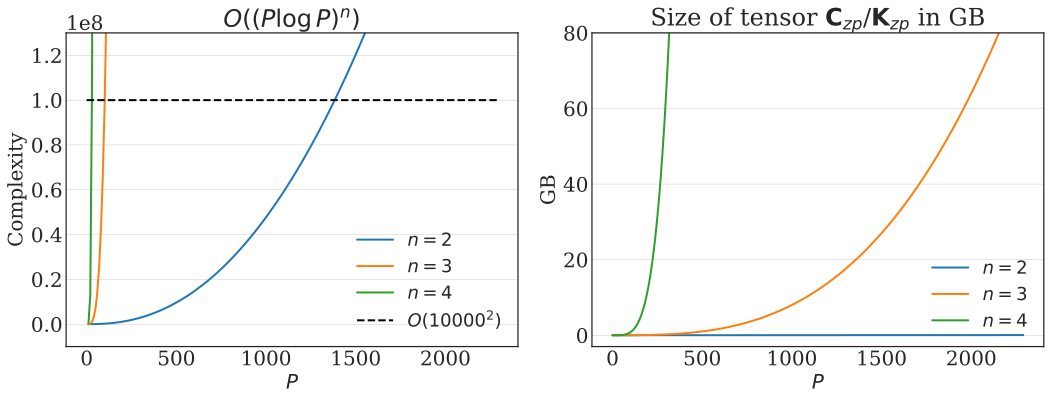

In [4]:
y2 = np.array([plogp(i,2) for i in range(0,2300,10)])
y3 = np.array([plogp(i,3) for i in range(0,2300,10)])
y4 = np.array([plogp(i,4) for i in range(0,2300,10)])
yN2 = np.array([10000**2 for i in range(0,2300,10)]) 
ysize2 = np.array([matrix_size(i,2) for i in range(0,2300,10)])
ysize3 = np.array([matrix_size(i,3) for i in range(0,2300,10)])
ysize4 = np.array([matrix_size(i,4) for i in range(0,2300,10)])

x = np.arange(0,2300,10)
fig,axes = plt.subplots(1,2, figsize=(15,6))
ax1, ax2 = axes.flatten()
ax1.plot(x, y2, label=r'$n=2$')
ax1.plot(x, y3, label=r'$n=3$')
ax1.plot(x, y4, label=r'$n=4$')
ax1.plot(x, yN2, 'k',linestyle='--', label=r'$O(10000^2)$')
ax1.legend(loc='lower right')
ax1.grid(axis='y', linestyle='-', color='gray', alpha=0.5)
ax1.set_ylim(-10e6,1.3e8)
ax1.set_xlabel(r'$P$')
ax1.set_ylabel('Complexity')
ax1.set_title(r'$O((P\log P)^n)$')

ax2.plot(x, ysize2, label=r'$n=2$')
ax2.plot(x, ysize3, label=r'$n=3$')
ax2.plot(x, ysize4, label=r'$n=4$')
ax2.legend(loc='lower right')
ax2.grid(axis='y', linestyle='-', color='gray', alpha=0.5)
ax2.set_ylim(-3,80)
ax2.set_xlabel(r'$P$')
ax2.set_ylabel('GB')
ax2.set_title(r'Size of tensor $\mathbf{C}_{zp}$/$\mathbf{K}_{zp}$ in GB')
fig.tight_layout()
fig.savefig('results/fft_complexity.pdf', format='pdf', bbox_inches='tight')


In [103]:

# Example usage:
P = 256
n = 3
print(f"The size of the matrix is {matrix_size(P, n)} bytes.")

The size of the matrix is 0.134217728 bytes.
